In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import shutil

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

In [32]:
# Set up GPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [256, 256]
OUTPUT_CHANNELS = 3
EPOCHS = 25
BATCH_SIZE = 1

In [34]:
monet_path = 'data/monet-gan/monet_tfrec/*.tfrec'
photo_path = 'data/monet-gan/photo_tfrec/*.tfrec'

In [35]:
# Load and prepare dataset
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    return decode_image(example['image'])

def load_dataset(filenames, labeled=True):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE)

In [36]:
# Define filepaths
monet_filenames = tf.io.gfile.glob(monet_path)
photo_filenames = tf.io.gfile.glob(photo_path)

monet_ds = load_dataset(monet_filenames)
photo_ds = load_dataset(photo_filenames)

print('Monet TFRecord Files:', len(monet_filenames))
print('Photo TFRecord Files:', len(photo_filenames))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


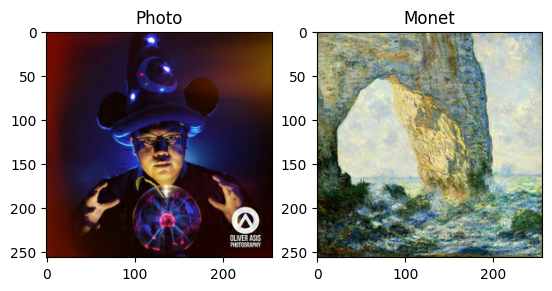

In [37]:
# Display sample photos
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)
plt.show()

In [38]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_norm:
        block.add(tfa.layers.InstanceNormalization())

    block.add(tf.keras.layers.LeakyReLU())

    return block

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    block.add(tfa.layers.InstanceNormalization())

    if apply_dropout:
        block.add(tf.keras.layers.Dropout(0.5))

    block.add(tf.keras.layers.ReLU())

    return block

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [39]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)

    x = tf.keras.layers.ZeroPadding2D()(x)
    x = tf.keras.layers.Conv2D(512, 4, strides=1,
                               kernel_initializer=initializer,
                               use_bias=False)(x)

    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.ZeroPadding2D()(x)
    x = tf.keras.layers.Conv2D(1, 4, strides=1,
                               kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inp, outputs=x)


In [40]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def calc_cycle_loss(real_image, cycled_image, LAMBDA=10):
    cycle_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * cycle_loss

def identity_loss(real_image, same_image, LAMBDA=10):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss


In [41]:
class CycleGan(tf.keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            fake_photo = self.p_gen(real_monet, training=True)

            cycled_monet = self.m_gen(fake_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            total_monet_gen_loss = monet_gen_loss + self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle) + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


In [42]:
with strategy.scope():

    monet_generator = Generator()
    photo_generator = Generator()
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer=monet_generator_optimizer,
        p_gen_optimizer=photo_generator_optimizer,
        m_disc_optimizer=monet_discriminator_optimizer,
        p_disc_optimizer=photo_discriminator_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )


In [43]:
# Run the cycle GAN model
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
)

Epoch 1/25
150/150 [==============================] - 76s 217ms/step - monet_gen_loss: 3.8764 - photo_gen_loss: 4.2544 - monet_disc_loss: 0.7049 - photo_disc_loss: 0.7163
Epoch 2/25
150/150 [==============================] - 31s 209ms/step - monet_gen_loss: 2.8000 - photo_gen_loss: 2.8839 - monet_disc_loss: 0.6648 - photo_disc_loss: 0.6714
Epoch 3/25
150/150 [==============================] - 31s 209ms/step - monet_gen_loss: 2.5328 - photo_gen_loss: 2.6489 - monet_disc_loss: 0.6541 - photo_disc_loss: 0.6618
Epoch 4/25
150/150 [==============================] - 31s 208ms/step - monet_gen_loss: 2.4536 - photo_gen_loss: 2.6014 - monet_disc_loss: 0.6547 - photo_disc_loss: 0.6592
Epoch 5/25
150/150 [==============================] - 31s 208ms/step - monet_gen_loss: 2.4218 - photo_gen_loss: 2.5749 - monet_disc_loss: 0.6529 - photo_disc_loss: 0.6570
Epoch 6/25
150/150 [==============================] - 31s 208ms/step - monet_gen_loss: 2.4009 - photo_gen_loss: 2.5588 - monet_disc_loss: 0.6543 

In [46]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def calculate_fid(model, real_images, generated_images):
    real_images = tf.image.resize(real_images, (299, 299))
    generated_images = tf.image.resize(generated_images, (299, 299))
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)
    act1 = model.predict(real_images)
    act2 = model.predict(generated_images)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


87910968/87910968 [==============================] - 3s 0us/step


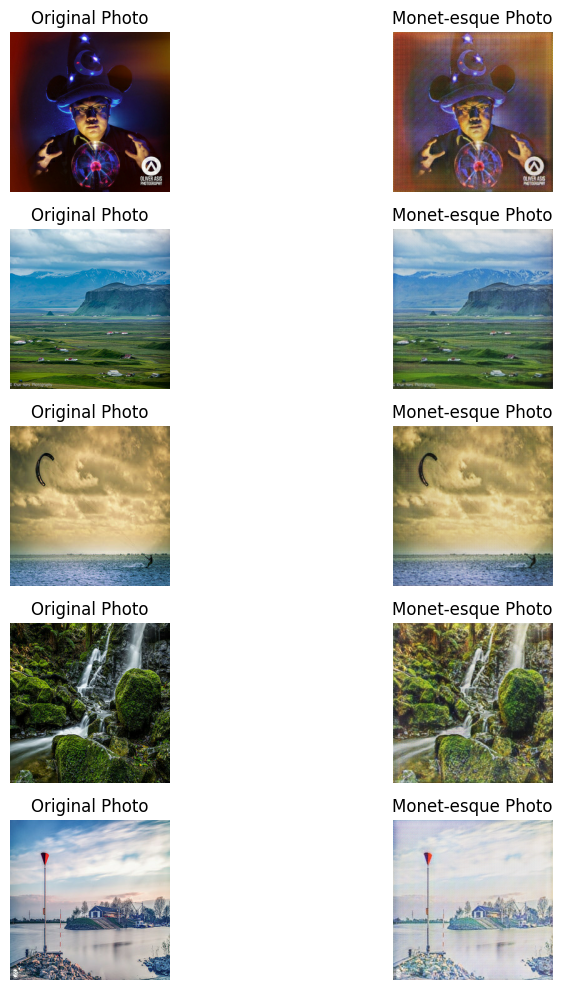

1/1 [==============================] - 0s 30ms/step
FID score: 5.96787883691744e+88


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
def display_and_save_generated_images(dataset, generator, model, num_samples=5):
    plt.figure(figsize=(10, num_samples * 2))
    real_images = []
    generated_images = []

    for i, img in enumerate(dataset.take(num_samples)):
        prediction = generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        original = (img[0].numpy() * 127.5 + 127.5).astype(np.uint8)

        real_images.append(original)
        generated_images.append(prediction)

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.title("Original Photo")
        plt.imshow(original)
        plt.axis('off')

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.title("Monet-esque Photo")
        plt.imshow(prediction)
        plt.axis('off')

        im = Image.fromarray(prediction)
        save_image(im, f'monet_{i+1}.png')

    plt.tight_layout()
    plt.show()

    real_images = np.array(real_images).astype('float32')
    generated_images = np.array(generated_images).astype('float32')
    fid_score = calculate_fid(model, real_images, generated_images)
    print(f"FID score: {fid_score}")

display_and_save_generated_images(photo_ds, monet_generator, model, num_samples=5)
shutil.make_archive('monet_images', 'zip', 'images')

try:
    from google.colab import files
    files.download('monet_images.zip')
except ImportError:
    print("Files can be manually downloaded.")


In [45]:
images_dir = 'data/monet-gan/generated-images'
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(f"{images_dir}/{i+1}.jpg")

shutil.make_archive('data/monet-gan/monet-images', 'zip', images_dir)

'/content/data/monet-gan/monet-images.zip'